# Lecture 7: Implementing iterative optimization algorithms

We want to understand how different iterative algorithms work in terms of optimization. We will consider *gradient descent*, *newton's method*, and *stochastic gradient descent*. We have not seen the last one yet, but will discuss it below.

Let's briefly recall some notation. For a given function $f : \mathbb{R}^d \mapsto \mathbb{R}$, the gradient of that function evaluated at a point $x \in \mathbb{R}^d$ is
$$
\nabla f(x) = \left (\frac{\partial f(x)}{x[1]} , ... , \frac{\partial f(x)}{x[d]} \right )^T
$$
where we take the transpose because we assume that the gradient is a column vector.

## Gradient descent
We recall that gradient descent acts as a steepest descent method. The negative gradient is the **local** steepest direction.
$$
x_{k+1} = x_{k} - \eta_k \nabla f(x_k)
$$
One interpretation of this is that we can approximate $f$ locally as a linear function
$$
f_L(x) = f(x_k) + \langle \nabla f(x_k) , x-x_k \rangle
$$
Now, if we want to minimize the above we have that the minimum value of $f_L(x)$ is $-\infty$. So instead we just take a very small step so that the approximation $f_L(x) \approx f(x)$ is valid enough.
## Newton's method
Newton's method uses both the first derivative (gradient) and second derivative (Hessian) of the multivariate function $f$. Recall that the Hessian of a function is a $d \times d$ matrix $H_{f(x)}$ where the $i,j^{th}$ entry of the matrix is
$$
H_{f(x)}[i,j] = \frac{\partial^2{f(x)}}{\partial x[i] \partial x[j]}
$$

We recall the following algorithm
$$
x_{k+1} = x_{k} - \eta_k H_{f(x_k)}^{-1} \nabla f(x_{k})
$$
One intuitive explanation for this method is that locally the function $f$ can be approximated as
$$
f(x) \approx \tilde{f}(x) = f(x_k) + \langle \nabla f(x_k) , x-x_k \rangle + \frac{(x-x_k)^T H_{f(x_k)} (x-x_k)}{2}
$$
The above is the multi-dimensional generalization of [Taylor's theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem#Taylor.27s_theorem_for_multivariate_functions) (this link points to wikipedia)

Given that we can optimize the above (as in Lecture Notes 3) we set the gradient
$$
\nabla \tilde{f}(x) = \nabla f(x_k) + H_{f(x_k)}(x-x_k)
$$

### Step size
The step size in the choices above are selected in such a way to keep the optimization stable. One heuristic reason for this is because both gradient descent and Newton's method are approximating the function we wish to optimize locally by a linear (gradient descent) or quadratic (Newton's method) function. For that approximation to be accurate we cannot step too far away from the original point $x_k$. Hence, the choice of step-size aims to keep the next iterate $x_{k+1}$ within the region where the linear or quadratic approximations of $f$ are well behaved.

# Simple example for gradient descent versus Newton's method

In [96]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import scipy.linalg as la
%matplotlib inline

Below we construct an example for optimizing the function
$$
f(x,y) = \textrm{scalex} \times x^2 + \textrm{scaley} \times y^2
$$
We will focus on $x,y \in [-10,10]$

In [2]:
myrange=10
X,Y=np.meshgrid(np.arange(-myrange,myrange,0.1),np.arange(-myrange,myrange,0.1))
scalex=1
scaley=.01
Z=scalex*X**2+scaley*Y**2

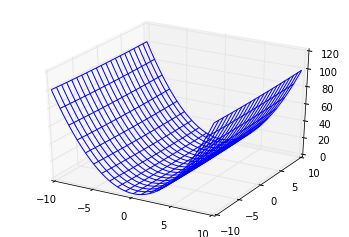

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

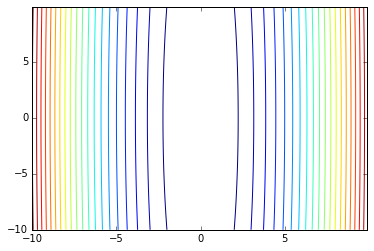

In [4]:
plt.contour(X,Y,Z,20)

How we define a function to compute the gradient of $f$
$$
\nabla f(x,y) = (2 \textrm{ scalex } x , 2 \textrm{ scaley } y)^T
$$
and the Hessian
$$
H = \left ( \begin{matrix} 2 \textrm{ scalex } & 0 \\ 0 & 2 \textrm{ scaley }  \end{matrix} \right )
$$
Note that the Hessian is the same for all $x$ and $y$

In [5]:
def easy_gradient(x):
    return 2*np.array([scalex,scaley])*x

In [6]:
def easy_newton(x):
    return 2*np.diag([scalex,scaley])

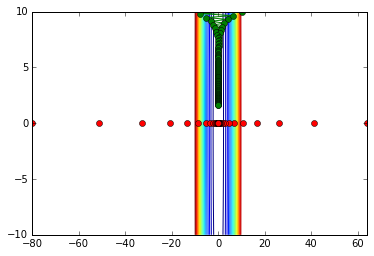

In [7]:
ITERS=100
plt.contour(X,Y,Z,20)
xk=np.array([100,0])
xj=np.array([10,10])
Xj=np.zeros((ITERS+1,2))
Xj[0]=xj
for j in range(ITERS):
    xk=xk-0.9*easy_gradient(xk)
    Xj[j+1]=Xj[j]-0.9*easy_gradient(Xj[j])
    #plt.plot(xj[0],xj[1],'-og')
    plt.plot(xk[0],xk[1],'or')
plt.plot(Xj[:,0],Xj[:,1],'-og')
plt.show()

Above we see that gradient descent started at a strange point will oscillate a lot.

In [8]:
Xj[ITERS]

array([  2.03703598e-09,   1.62610572e+00])

In [9]:
xk

array([  2.03703598e-08,   0.00000000e+00])

Newton steps converge directly towards the global optimum.

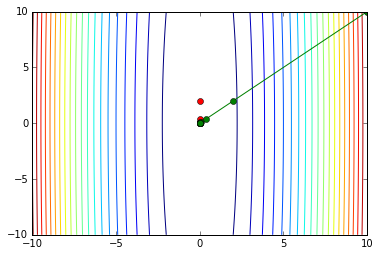

In [12]:
ITERS=10
plt.contour(X,Y,Z,20)
xk=np.array([0,10])
xj=np.array([10,10])
Xj=np.zeros((ITERS+1,2))
Xj[0]=xj
for j in range(ITERS):
    xk=xk-0.8*np.linalg.solve(easy_newton(xk),easy_gradient(xk))
    Xj[j+1]=Xj[j]-0.8*np.linalg.solve(easy_newton(Xj[j]),easy_gradient(Xj[j]))
    plt.plot(xk[0],xk[1],'or')
plt.plot(Xj[:,0],Xj[:,1],'-og')

In [13]:
Xj[ITERS]

array([  1.02400000e-06,   1.02400000e-06])

In [14]:
xk

array([  0.00000000e+00,   1.02400000e-06])

# Logistic Regression Example
Below we will run through various different examples of logistic regression and see how different quantities might influence the behavior. Specifically we want to do binary classification. First we set up the data. To make things simple we assume that each of the entries of the matrix $A$ are normal distributed with mean zero and variance one.

We generate the samples as follows
$$
b[i] = \begin{cases} +1 & \textrm{if $U[i] < 1/(1+\exp(-a_i^T x^*))$} \\
    0 & \textrm{otherwise}
\end{cases}
$$
where $U[i]$ is a uniform sample drawn, which can be drawn from the `numpy.random.rand`. What that means is that the label is $+1$ with probability $1/(1+\exp(-a_i^T x^*))$. Intuitively, the more aligned $a_i$ is with $x^*$ the more likely that the label is $+1$.

In [91]:
np.random.seed(1)
PLOTFLAG=True
n=100
d=2
renormalizematrix=np.random.normal(0,1,(d,d))/np.sqrt(d)
renormalizematrix=np.identity(d)
A=np.random.normal(0,1,(n,d)).dot(renormalizematrix)
xstar=np.random.normal(0,1,(d,))
xstar=xstar/np.linalg.norm(xstar)
v=np.exp(-A.dot(xstar))
v.shape

(100,)

In [92]:
b=np.less_equal(np.random.rand(n),1/(1+v))
b=np.float64(b)
b.shape

(100,)

Below is a plot of the data with the $2$-dimensional example. Note that in higher dimensions it is much harder to visualize the difference between blue and red.

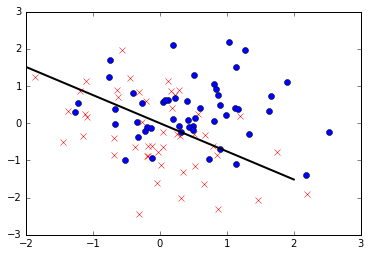

[-0.6033098  -0.79750692]


In [93]:
if PLOTFLAG:
    x1=-2
    x2=2
    plt.plot(A[b==1,0],A[b==1,1],'rx')
    plt.plot(A[b==0,0],A[b==0,1],'bo')
    plt.plot([x1, x2], [-x1*xstar[0]/xstar[1], -x2*xstar[0]/xstar[1]], color='k', linestyle='-', linewidth=2)
    plt.show()
print(xstar)

Notice that in the direction of `xstar` there are more $+1$s than $0s$.

In [94]:
xsd=xstar*0
xsgd=xstar*0
xnewton=xstar*0

We will now solve the above classification problem using *Logistic Regression*. The classification setting is like the linear regression one. In the classification setting we have features $a_i \in \mathbb{R}^d$ and responses $b_i \in \{0,1\}$. Our goal is to learn a weight vector $x$ such that $1(x^T a_i \geq 0) = b_i$ most of the time where we recall that

$$
1(A) = \begin{cases} 1 & \textrm{if $A$ is true} \\ 0 & \textrm{otherwise} \end{cases}
$$
Basically, we predict that $b_i$ is $+1$ if $x^T a_i \geq 0$, and we predict $b_i$ is $0$ otherwise.

We could solve this using linear regression and just treat $b_i$ and a real outcome, but let's explore logistic regression, which performs better in practice. In logistic regression, to find our weight vector $x$, we optimize
$$
\hat{x} = \arg \min_{x} \sum_{i=1}^n \log(1+\exp(a_i^T x)) - b_i a_i^T x
$$

Note that the actual categories of $b_i$ do not matter. Simply relabel the two categories to be one and zero. Nevertheless, it is often the case that packages might want $b_i \in \{-1,+1\}$. In that case the optimization takes a different form
$$
\hat{x} = \arg \min_{x} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^T x))
$$
This form has the advantage that we want $b_i = \textrm{sign(x^T a_i)}$ most of the time, where
$$
\textrm{sign}(s) = \begin{cases} 1 & \textrm{if $s \geq 0$} \\ -1 & \textrm{otherwise} \end{cases}
$$
## Why does this optimization make sense?
To understand this optimization, let's see what we want to minimize in classification. Here, we will stick to the case where $b_i \in \{-1,+1\}$. One way to find the best $\hat{x}$ is to optimize
$$
\hat{x} = \arg \min_{x} \frac{1}{n} \sum_{i=1}^n 1(a_i^T x b_i \leq 0)
$$
Basically, what the above is doing is it is counting the number of times that $a_i^T x$ and $b_i$ have different signs, meaning that $\textrm{sign}(a_i^T x) \neq b_i$. Therefore, the above is minimizing the average error of picking the sign. Unfortunately, unless there is a solution $\hat{x}$ such that the above is equal to zero, then solving the above problem is computationally intractable. Rather, authors look to convex surrogates for $1(s \leq 0)$. Basically, functions that are more amenable to optimization, yet can still encourage $a_i^T x$ and $b_i$ to have the same signs.

In logistic regression, that selected function is
$$
\psi(s) = \log(1+\exp(-s))/\log(2)
$$
Let's plot the two functions. (Note that the $\log(2)$ above doesn't matter for the optimization, but it makes the plot below more interpretable)

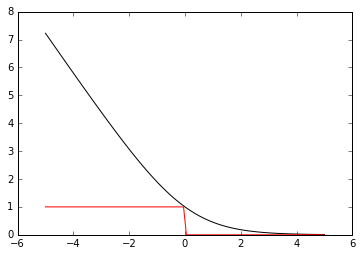

In [102]:
s=np.linspace(-5,5,100)
psi=np.log(1+np.exp(-s))/np.log(2)
indicator=(s<=0)*1.0
plt.plot(s,psi,'k')
plt.plot(s,indicator,'r')

What we see is that the black line is in fact a convex upper-bound on the red one. It has the nice behavior that $\psi(a_i^T x b_i)$ is small if $a_i^T x b_i \geq 0$ and it is large otherwise. The function $\psi(s)$ is penalizing errors (when $a_i^T x b_i \leq 0$) much more than correct predictions (when $a_i^T x b_i \geq 0$). One point to note is that $\psi(s)$ penalizes big errors, whereas $1(s \leq 0)$ counts all errors as the same. Big errors are those where $a_i^T x b_i$ is much much smaller than zero ($a_i^T x b_i \ll 0$). There is a substantial amount of theory discussing why such a convex surrogate should behave well. We briefly note that one could also use the least squares error for this task. That is, we could optimize
$$
\arg \min_{x} \sum_{i=1}^n (a_i^T x - b_i)^2
$$
The above is very reasonable because we are are simply trying to learn an $x$ such that $a_i^T x$ is close to $b_i$.
We can make a slight modification. We have
$$
(a_i^T x - b_i)^2 = ((a_i^T x b_i - 1) \times b_i)^2
= b_i^2 (a_i^T x b_i - 1)^2
= (a_i^T x b_i - 1)^2
$$
The last equality follows because $b_i^2 = 1$. Now define
$$
\gamma(s) = (s-1)^2
$$
and by above the least squares method for handling classification is to optimize
$$
\arg \min_{x} \sum_{i=1}^n \gamma(a_i^T x b_i)
$$
Let's plot the function against the indicator $1(s \leq 0)$

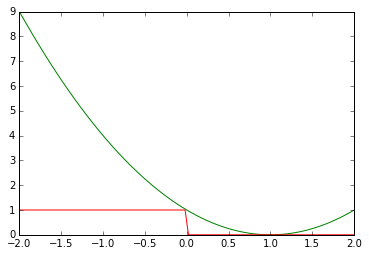

In [106]:
s=np.linspace(-2,2,100)
gamma=(s-1)**2
plt.plot(s,gamma,'g')
indicator=(s<=0)*1.0
plt.plot(s,indicator,'r')

What we see is that the function $\gamma$ also penalizes errors. However, the problem is that if an estimate is *very* correct, that is if $a_i^T x b_i \gg 1$, then the function actually penalizes the correct estimate.

Let's now explore logistic regression and define the a function that evaluates the logistic regression loss given a weight vector $x$.

In [107]:
def evalfunc(x):
    v=A.dot(x)
    return (np.sum(np.log(1+np.exp(v)))-np.sum(b*v))/A.shape[0]

Now let's define the gradient
$$
\nabla f = \sum_{i=1}^n \left ( \frac{1}{1+\exp(-a_i^T x)} - b_i \right ) a_i \quad \quad
$$
You might notice that there are two ways to do the above. An equivalent version is
$$
\nabla f = \sum_{i=1}^n \left ( \frac{\exp(a_i^T x)}{1+\exp(a_i^T x)} - b_i \right ) a_i \quad \quad
$$
The former is better for numerical reasons.

In [108]:
def grad(x,sampleind=-1):
    if sampleind>=0:
        v=np.exp(-A[sampleind].dot(x))
        return (1/(1+v)-b[sampleind])*A[sampleind].reshape(x.shape)
    else:
        v=np.exp(-A.dot(x))
        return A.T.dot(((1/(1+v))-b.reshape(v.shape))/A.shape[0])

In [109]:
v=np.exp(-A.dot(xsd))
b.shape

(100,)

In [110]:
delta=0.0001
u=np.random.normal(0,1,(d,))
xsgd=np.random.normal(0,1,(d,))
print (evalfunc(xsd+delta*u)-evalfunc(xsd))/delta,u.T.dot(grad(xsd))

-0.0313176370204 -0.0313179732412


Want to define some function to compute the Hessian at a given point
$$
\sum_{i=1}^n \frac{\exp(a_i^T x)}{(1+\exp(a_i^T x))^2} a_i a_i^T
$$

In [111]:
def realnewton(x):
    errr=A.dot(x)/2
    v=1/(np.exp(errr)+np.exp(-errr))**2/A.shape[0]
    return (A.T).dot((v).reshape((n,1))*(A))

Below we pick a random point and numerically evaluate the derivative to do a sanity check. Numerically checking is a useful method to make sure that your gradient function is correct.

Check Hessian

In [25]:
delta=0.0001
u=np.random.normal(0,1,(d,1))
xsgd=np.random.normal(0,1,(d,1))
print (evalfunc(xsgd+delta*u)-2*evalfunc(xsgd)+evalfunc(xsgd-delta*u))/delta**2,u.T.dot(realnewton(xsgd).dot(u))

0.0455344206785 [[ 0.04553276]]


## Gradient descent algorithm

In [26]:
def graddescent(x0,grad,stepsize,newton=None,maxiter=10000,SGD=False):
    xk=np.copy(x0)
    xe=np.copy(x0)
    itercount=0
    n=A.shape[0]
    while itercount < maxiter:
        itercount+=1
        if SGD:
            sampleind=itercount%n #np.random.choice(A.shape[0])
#            xk=xk-stepsize/np.sqrt(itercount)*grad(xk,sampleind=sampleind)
            xk=xk-stepsize*grad(xk,sampleind=sampleind)
            xe=xe*(itercount-1)/itercount+xk/itercount
        else:
            if newton:
                xk=xk-stepsize*np.linalg.solve(newton(xk)/n,grad(xk)/n)
            else:
                xk=xk-stepsize*grad(xk)
    if SGD:
        return xe
    else:
        return xk

Let's do a simple check to compare gradient descent and Newton's method

In [27]:
starttime=time.time()
xgraddescent=graddescent(xsd,grad,0.7,maxiter=100)
print time.time()-starttime

0.00479793548584


In [28]:
np.linalg.norm(grad(xgraddescent))

0.00016664241453146915

In [29]:
starttime=time.time()
xsolution=graddescent(xsd,grad,.5,newton=realnewton,maxiter=15)
print time.time()-starttime

0.00262808799744


In [30]:
np.linalg.norm(grad(xsolution))

8.1972787515266401e-06

Looking above we see that newton's method achieves $2$ order's of magnitude better behavior in the norm of the gradient at the solution, and did it in half the time. However, remember that in this setting we have $d$ and $n$ both pretty small.

Below, we are looking at the direction between the Newton method and the gradient descent method compared to the true optimal solution that we used to generate the data.

In [33]:
np.sum(xsolution*xstar)/np.linalg.norm(xsolution)/np.linalg.norm(xstar)

0.99170911595667888

In [34]:
np.sum(xgraddescent*xstar)/np.linalg.norm(xgraddescent)/np.linalg.norm(xstar)

0.99172326351055684

We can vary $n$ and $d$, but we see that Newton method took an order of magnitude longer to compute, but is more aligned with `xstar`. Nevertheless, we're talking microseconds for this size problem, so we can manage that.

## Let's try different values of $n$ and $d$

In [35]:
np.random.seed(1)
PLOTFLAG=True
n=10000
d=1000
renormalizematrix=np.random.normal(0,1,(d,d))/np.sqrt(d)
renormalizematrix=np.identity(d)
A=np.random.normal(0,1,(n,d)).dot(renormalizematrix)
xstar=np.random.normal(0,1,(d,))
xstar=xstar/np.linalg.norm(xstar)
v=np.exp(-A.dot(xstar))
v.shape
xsd=xstar*0
b=np.less_equal(np.random.rand(n),1/(1+v))
b=np.float64(b)
b.shape

(10000,)

In [36]:
starttime=time.time()
xgraddescent=graddescent(xsd,grad,0.7,maxiter=100)
print time.time()-starttime

1.26422691345


In [37]:
np.linalg.norm(grad(xgraddescent))

0.00014558037121405309

In [40]:
starttime=time.time()
xsolution=graddescent(xsd,grad,.5,newton=realnewton,maxiter=10)
print time.time()-starttime

4.40580296516


In [41]:
np.linalg.norm(grad(xsolution))

0.00036151708604428075

This time around, Newton's method takes much longer even though it is taking far fewers iterations. The problem is that we have to both store a Hessian matrix, which takes $O(d^2)$ space, and each iteration also has to solve a system of linear equations which takes $O(d^3)$.

Now, we see that taking $d$ to be quite large makes the Newton's step prohibitively expensive. Now, what do we do when $n$ is very very large. In that case, it can be wasteful to have to compute a full gradient for every iteration. Why can't we just make updates with partial gradient updates?

# Stochastic Gradient Descent
We now discuss stochastic gradient descent (SGD). It is a widely used algorithm with a broad range of applications and settings that it can be used. In machine learning applications the most widely used setting is when the objective function takes the form
$$
f(x) = \sum_{i=1}^n f_i(x)
$$

In that case, the algorithm works as follows. At each iteration, we pick some index $L$ uniformly at random from $[n]$ and update to the next iterate as follows
$$
x_{k+1} = x_k - \eta_k \nabla f_L(x)
$$
It's important to note that this is not necessarily a descent direction. Nevertheless, we hope that the iterates decrease on average.

The above update only needs to compute the gradient for a single $L$. Contrast that with standard gradient descent where it is the sum over all $i \in [n]$. Therefore, the computational cost of performing the SGD step is $O(n)$ faster than a standard gradient step. One of the biggest advantages of SGD is that it can make constant adjustments at each time a data point is processed. This is in contrast to normal gradient descent where we must first sum all of the gradients over each of the data points before we can make a step. The SGD gradient step can be viewed as a noisy version of the normal gradient descent step, and in a large number of applications that noisy step is, on average, a good step.

It is still important to note that stochastic gradient descent is not actually a descent algorithm. The loss function need not decrease at each iteration because we are not using the exact gradient, only a noisy version of it. For that reason one must rely on either fixed step-sizes are decreasing ones. Some choices include setting the step size to be $O(1/\sqrt{n})$ where again $n$ is the number of examples. Another choice is to let the step-size be $O(1/\sqrt{k})$ where $k$ is the number of the current round in gradient descent. Therefore, the step-size is decreasing with time. This makes intuitive sense, because the gradient steps are noisy. Even if we are at the true minimizer of $f(x)$, the noisy SGD update will move us away. Hence, as time progresses we want to make sure that we decrease the amount of moves with the expectation that as time progresses we get closer to the optimal solution.

The above discussion of step-sizes is focused on convex problems. For non-convex we must generally rely on heuristics for selection of step-sizes. The constant step-size is a popular option, where it is decreased over time as less progress is made. Another option is that the steps are constant during various epochs of different sizes. Each epoch's length is doubled in size while the step size is halved.

Below we have an example demonstrating the difference between SGD and standard gradient descent. SGD is the most popular choice for optimization at large scale because in general doing full gradient descents are impractical because we can only take a step after a single loop through the entire dataset.

In [80]:
np.random.seed(1)
PLOTFLAG=True
n=1000000
d=20
renormalizematrix=np.random.normal(0,1,(d,2*d))/np.sqrt(d)
renormalizematrix=renormalizematrix.dot(renormalizematrix.T)
#renormalizematrix=np.identity(d)
A=np.random.normal(0,1,(n,d)).dot(renormalizematrix)
xstar=np.random.normal(0,1,(d,))
xstar=xstar/np.linalg.norm(xstar)
v=np.exp(-A.dot(xstar))
v.shape
xsd=xstar*0
b=np.less_equal(np.random.rand(n),1/(1+v))
b=np.float64(b)
b.shape

(1000000,)

How fast does it take to compute the update on one example.

In [81]:
a=time.time()
v=A[:1].dot(xsd)
time.time()-a

0.0010190010070800781

How fast does it take to compute the update on all of the examples.

In [82]:
a=time.time()
v=A.dot(xsd)
time.time()-a

0.016463041305541992

Numpy is pretty fast even when n=1000000

In [83]:
starttime=time.time()
xsolution=graddescent(xsd,grad,.1/np.sqrt(60000),maxiter=80000,SGD=True)
print time.time()-starttime

1.20936608315


In [84]:
np.linalg.norm(grad(xsolution))

0.024901193052932466

In [85]:
np.sum(xsolution*xstar)/np.linalg.norm(xsolution)/np.linalg.norm(xstar)

0.96287610907964727

In [86]:
starttime=time.time()
xgraddescent=graddescent(xsd,grad,0.7,maxiter=1000)
print time.time()-starttime

60.7539889812


Gradient descent took longer, but the vector obtain from gradient descent `xgraddescent` is just as aligned with `xstar` as the one obtained by stochastic gradient descent, but SGD was much faster because $n$ was so large. If you were do actually implement things in `C` where for loops are compiled and much faster, then SGD would be orders of magnitude faster.

In [89]:
np.linalg.norm(grad(xgraddescent))

0.91288938291332544

In [90]:
np.sum(xgraddescent*xstar)/np.linalg.norm(xgraddescent)/np.linalg.norm(xstar)

0.97691202965247825

Below will take a while, so only run it if you want to see.

In [ ]:
starttime=time.time()
xsolution=graddescent(xsd,grad,.5,newton=realnewton,maxiter=20)
print time.time()-starttime

In [ ]:
np.linalg.norm(grad(xsolution))